## Credits 
1. UCI Machine Learning Repository (Sentence Classification Data Set )
2. Reuters-21578 Text Categorization Collection
3. Ana Cardoso Cachopo's Homepage
4. Peter norvig's website
5. http://www.sls.hawaii.edu/bley-vroman/brown_corpus.html

In [39]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
from collections import defaultdict
import string
from nltk.stem.porter import *
import time 
import random
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from scipy.optimize import curve_fit


## Create unigrams, bigrams and trigrams and from datasets

In [ ]:
unigram_count = dict() ## stores unigram counts
unigram_prob = dict() ## probability of words
bigram_count = dict(defaultdict(int) ) ## stores bigram counts
trigram_count = dict(defaultdict(defaultdict ) ) ## stores all trigram counts

fname = 'full_corpus.txt'
t = open(fname,'r')
temp = t.read()
data = []
for word in temp.split():
    # initialise unigrams
    if word not in unigram_count :
        unigram_count[word] = 0
    unigram_count[word] += 1
    data.append( word )

    # initialise bigrams
    if len(data) >= 2 :
        w1 = data[-2]
        w2 = data[-1]
        if w1 not in bigram_count :
            bigram_count[w1] = defaultdict(int)
        bigram_count[w1][w2] += 1

    # initialise trigrams
    if len(data) >= 3 :
        w1 = data[-3]
        w2 = data[-2]
        w3 = data[-1]
        if w1 not in trigram_count :
            trigram_count[w1] = defaultdict( defaultdict )
        if w2 not in trigram_count[w1] :
            trigram_count[w1][w2] = defaultdict(int) 
        trigram_count[w1][w2][w3] += 1 

t.close()

unigrams = set(unigram_count.keys())
bigrams = set(bigram_count.keys())
trigrams = set(trigram_count.keys())

total_words = sum(unigram_count.values())
for w in unigrams :
    unigram_prob[w] = unigram_count[w]/total_words 

common_unigrams = [x for _,x in sorted(zip(unigram_prob.values(), unigram_prob.keys()), reverse = True)]

## Creating wordclouds

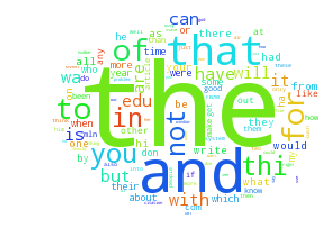

In [49]:
text = open('full_corpus.txt').read()
stopwords1 = set(' ')
mask1 = np.array(Image.open("image.jpg"))
wc = WordCloud(background_color="white", max_words=1000, mask=mask1, stopwords=stopwords1)
wc.generate(text)
# plt.imshow(wc, interpolation='bilinear')
plt.imshow(wc)
plt.axis("off")
plt.show()

## Bar graph of most frequent unigrams

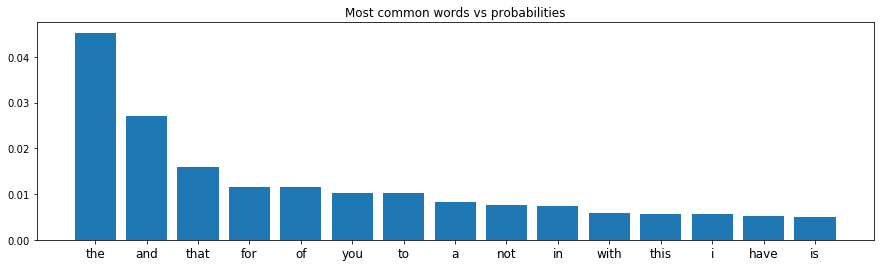

In [40]:
xx = common_unigrams[:50]
yy = [unigram_prob[x] for x in xx]
xx = xx[:15]
yy = yy[:15]
fig = plt.figure()
x1 = np.array( list(range(len(yy))) )
plt.figure(figsize=(15,4))
plt.xticks(x1,xx, fontsize = 12)
plt.bar(x1,yy)
plt.title('Most common words vs probabilities')
plt.show()


## Curve fitting unigram barg graph to find underlying probability density function

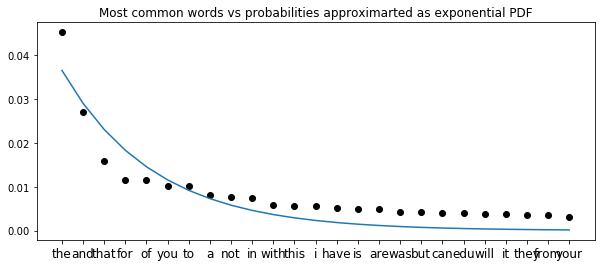

With lamda = 0.0366


In [41]:
xx = common_unigrams[:50]
yy = [unigram_prob[x] for x in xx]
xx = xx[:25]
yy = yy[:25]
x1 = np.array( list(range(len(yy))) )

def func(x, a,b):
    return a*np.exp(-a*x*b)

plt.figure(figsize=(10,4))
popt, pcov = curve_fit(func, x1, yy, p0=(5,0.5))
yy1 = func(x1, *popt)
plt.plot(x1, yy, 'ko')
plt.plot(x1, yy1 )
plt.xticks(x1,xx, fontsize = 12)
plt.title('Most common words vs probabilities approximarted as exponential PDF')
plt.show()
print('With lamda = %2.4f' %popt[0])

## Functions to predict next word distribution using n grams

In [10]:
# predict next word distribution from bigrams
def bigramprobs(w1, lam=1 ) :
    count = 0
    nextword_prob = defaultdict(float)
    for w2 in bigram_count[w1] :
        if len(w2) > 1 :
            nextword_prob[w2] += bigram_count[w1][w2] * lam
            count += bigram_count[w1][w2]
    for w in nextword_prob :
        nextword_prob[w] /= count
    return nextword_prob

# predict next word distribution from trigrams
def trigramprobs(w1,w2, lam = 1) :
    nextword_prob = defaultdict(float)
    count = 0
    for w3 in trigram_count[w1][w2] :
        if len(w3) > 1 :
            nextword_prob[w3] += lam * trigram_count[w1][w2][w3]
            count += trigram_count[w1][w2][w3]
    for w in nextword_prob :
        nextword_prob[w] /= count
    return nextword_prob

def probablewords(next_word, n = 10) :
    temp = list( next_word.values() ) 
    temp.sort(reverse=True)
    if len(temp) > n :
        probs = temp[:n]
    else :
        n = len(temp)
        probs = temp
    count = 0
    probable_words = []
    probabilities = []
    for w,p in next_word.items() :
        if p >= min( probs )  and count < n :
            count+= 1
            probable_words.append(str(w))
            probabilities.append(p)
            
    probable_words = [x for _,x in sorted(zip(probabilities, probable_words), reverse = True)]
    probabilities.sort(reverse = True)
    return probable_words, probabilities

    

## n-gram mixture model training

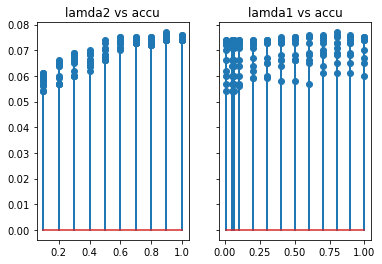

Best result has accuracy = 0.077  for lam2 =  0.9  and lam1 = 0.8
Elapsed time(s) =  2633.3
Best values of lamda3, lamda2 and lamda1, which are weights of tri, bi and unigrams : 
1,  0.9  and  0.8


In [184]:
t1 = time.time()
trainpath = 'train.txt'
train = []
bigram_t = []
trigram_t = []

for path in [trainpath] :
    files = glob.glob(path)
    for f in files :   
        t = open(f,'r') # open and read each file, to get text data
        temp = t.read()
        temp = ''.join([c for c in temp.lower() if not c in punctuation])
        for word in temp.split():
            train.append( word )
            if len(train) >= 3 :
                trigram_t.append( train[len(train)-3]+' ' +train[len(train)-2]+' ' +train[len(train)-1] )
        t.close()

trigram_train = list(set(trigram_t))

random.shuffle(trigram_train)
trigram_t = trigram_train[:1000]

top_unigrams = common_unigrams[:50]
accu = []
lam2 = []
lam1 = []
for l2 in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] :
    for l1 in [0.01,0.05,0.07,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] :
        lam2.append(l2)
        lam1.append(l1)
        pred = []
        for trainword in trigram_t :
            next_words = top_unigrams
            word1,word2,word3 = trainword.split()
            if word1 in trigram_count :
                if word2 in trigram_count[word1] :
                    tri_prob = trigramprobs(word1,word2) 
            else :
                tri_prob = None
            if word2 in bigram_count :
                bi_prob = bigramprobs(word2, l2 )
            else :
                bi_prob = None
            
            if bi_prob :
                next_words = set( list(next_words) + list(bi_prob.keys()) )
            if tri_prob :
                next_words = set( list(next_words) + list(tri_prob.keys()) )
                
            word_pred_prob = defaultdict(float) 
            for w in next_words :
                word_pred_prob[w] = l1*unigram_prob[w] 
                if tri_prob :
                    if w in tri_prob:
                        word_pred_prob[w] += tri_prob[w]
                if bi_prob :
                    if w in bi_prob:
                        word_pred_prob[w] += bi_prob[w]

            if max(word_pred_prob, key=word_pred_prob.get) == word3 :
                pred.append(1)
            else :
                pred.append(0)

        accu.append(sum(pred)/len(pred))


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.stem(lam2,accu)
ax1.set_title('lamda2 vs accu')
ax2.stem(lam1,accu)
ax2.set_title('lamda1 vs accu')
plt.show()

# for i in range(len(accu)) :
#     print('accu =',accu[i], 'lam2 = ' ,lam2[i], 'lam1 =',lam1[i])

results1 = [(x,y,z) for x,y,z in sorted(zip(accu,lam2,lam1), reverse = True)]
print('Best result has accuracy =',results1[0][0], ' for lam2 = ' ,results1[0][1], ' and lam1 =',results1[0][2])

t2 = time.time()
print('Elapsed time(s) = ', round( t2 - t1, 2) )

# the above code snippet is used to train hyper paramemters lamda1 and lambda2, to be used in the mixture
# model, which combines unigrams, bigrams and trigrams
lamda2 = results1[0][1]
lamda1 = results1[0][2]
print('Best values of lamda3, lamda2 and lamda1, which are weights of tri, bi and unigrams : ') 
print('1, ',lamda2, ' and ', lamda1)

## Next word suggestion using n-gram mixture model

-------------------------Mixture Model--------------------------- 
Enter any number of words (with space b/w words): Today is the day 

Next likely words are :  and , before


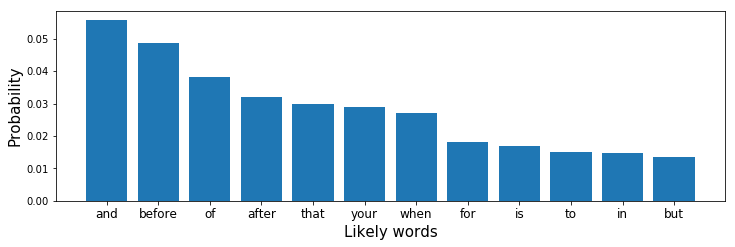

In [22]:
lamda2 = 0.9
lamda1 = 0.8
while True :
    print('-------------------------Mixture Model--------------------------- ')
    time.sleep(0.3) 
    temp = input('Enter any number of words (with space b/w words): ')
    temp = temp.lower()
    temp = list( temp.split() )
    if len(temp) >= 2 :
        word1,word2 = temp[-2], temp[-1]
        if word1 in unigrams and word2 in unigrams  :
            tri_prob = trigramprobs(word1,word2) 
            bi_prob = bigramprobs(word2, lamda2 )
            break
        else :
            print('Word combination was not in our dictionary ! Try again .... \n')
    if len(temp) == 1:
        word1 =''
        word2 = temp[0]
        if word2 in unigrams :
            bi_prob = bigramprobs(word2, lamda2 )
            tri_prob = {}
            break;
        else :
            print('Word combination was not in our dictionary ! Try again .... \n')

top_unigrams = common_unigrams[:50]
next_words = set( list(top_unigrams) + list(bi_prob.keys()) + list(tri_prob.keys()) )

word_pred_prob = defaultdict(float) 
sum1 = 0
for w in next_words :
    word_pred_prob[w] =  lamda1 * unigram_prob[w]
    if w in tri_prob:
        word_pred_prob[w] += tri_prob[w]
    if w in bi_prob:
        word_pred_prob[w] += bi_prob[w]
    if w == 'the' :
        word_pred_prob[w] /= 5
    sum1 += word_pred_prob[w]

for w in word_pred_prob :
    word_pred_prob[w] /= sum1

probable_words, probabilities = probablewords(word_pred_prob,12)
n = len(probable_words)

if n== 0 :
    print('\nCouldnt find any suggestions! Try a different combination')
if n==1 :
    print('\nNext likely word is : ',probable_words[0])
if n>=2 :
    print('\nNext likely words are : ',probable_words[0], ',' ,probable_words[1] )

if n > 2:
    plt.figure(figsize=(12,3.5))
    x = np.array( list(range(n)) )
    plt.xticks(x,probable_words, fontsize = 12)
    plt.bar(x,probabilities)
    plt.ylabel('Probability',fontsize=15)
    plt.xlabel('Likely words',fontsize=15)
    plt.show()